# Contrastive Learning Architecture from Scratch Using PyTorch

Building a Contrastive Learning Architecture from scratch can be done using either PyTorch or TensorFlow. I am implementing a SimCLR-like framework for this project. We will be taking the dataset CIFAR-10 for this project. 

**CIFAR-10**  is an established computer-vision dataset used for object recognition. It is a subset of the 80 million tiny images dataset and consists of 60,000 32x32 color images containing one of 10 object classes, with 6000 images per class.

Dataset Link: https://www.kaggle.com/c/cifar-10/

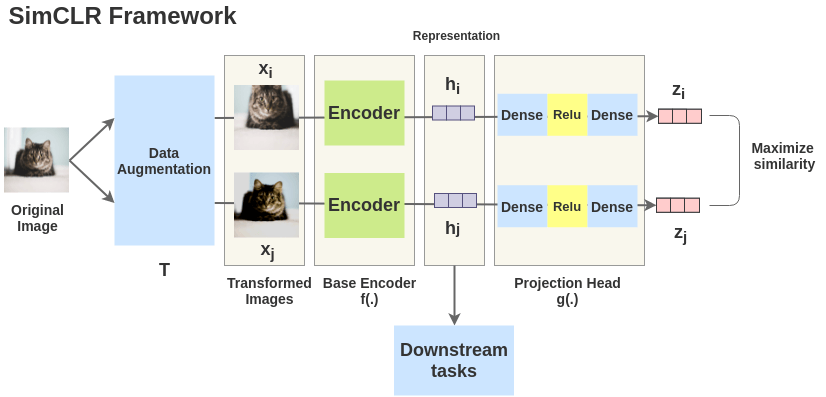

In [39]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score
import matplotlib.pyplot as plt
import numpy as np

In [21]:
class SimCLRTransform:
    """
        Data Augmentation - we apply strong agumentations for training purpose,
        create two different views on the same image. 
    """
    def __init__(self):
        self.augment = transforms.Compose([
            transforms.RandomResizedCrop(size=224),
            transforms.RandomHorizontalFlip(),
            transforms.RandomApply([
                transforms.ColorJitter(0.4, 0.4, 0.4, 0.1)
            ], p=0.8),
            transforms.RandomGrayscale(p=0.2),
            transforms.GaussianBlur(kernel_size=(3, 3), sigma=(0.1, 2.0)),
            transforms.ToTensor(),
            transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
        ])

    def __call__(self, x):
        return self.augment(x), self.augment(x)

In [14]:
class SimpleTransform:
    """
    Data Augmentation - we apply minimal augmentation for evaluation purpose.
    """
    def __init__(self):
        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
        ])

    def __call__(self, x):
        return self.transform(x)

In [15]:
class NTXentLoss(nn.Module):
    """
    We use NT-Xent Loss (Normalized Temperature-Scaled Cross-Entropy Loss) to 
    pull embeddings of similar images closer and push dissimilar images apart.
    """
    def __init__(self, temperature=0.5):
        super(NTXentLoss, self).__init__()
        self.temperature = temperature
        self.criterion = nn.CrossEntropyLoss()

    def forward(self, z_i, z_j):
        batch_size = z_i.size(0)

        # Normalize embeddings
        z_i = nn.functional.normalize(z_i, dim=1)
        z_j = nn.functional.normalize(z_j, dim=1)

        # Compute similarity matrix
        representations = torch.cat([z_i, z_j], dim=0)
        similarity_matrix = torch.matmul(representations, representations.T)

        # Remove self-similarity
        mask = torch.eye(2 * batch_size, device=similarity_matrix.device).bool()
        similarity_matrix = similarity_matrix[~mask].view(2 * batch_size, -1)

        # Positive similarity
        pos_sim = torch.cat([torch.diag(similarity_matrix, batch_size),
                             torch.diag(similarity_matrix, -batch_size)])

        # Labels
        labels = torch.arange(batch_size, device=z_i.device)
        labels = torch.cat([labels, labels])

        # Scale by temperature and compute loss
        similarity_matrix /= self.temperature
        return self.criterion(similarity_matrix, labels)

In [16]:
class SimCLR(nn.Module):
    """
    We use a feature extractor like ResNet to obtain image embeddings and 
    add a small network (e.g., MLP) to project embeddings to a latent space suitable for contrastive loss.
    
    Backbone - ResNet18 is used for simplicity but can be replaced with other models like ResNet50.
    
    Projection head - Maps embeddings to a lower-dimensional space to improve contrastive loss.
    """
    def __init__(self, backbone, projection_dim):
        super(SimCLR, self).__init__()
        self.backbone = backbone
        self.feature_dim = self.backbone.fc.in_features
        self.backbone.fc = nn.Identity()  # Remove classification head

        # Projection head
        self.projection_head = nn.Sequential(
            nn.Linear(self.feature_dim, projection_dim),
            nn.ReLU(),
            nn.Linear(projection_dim, projection_dim)
        )

    def forward(self, x):
        h = self.backbone(x)  # Extract features
        z = self.projection_head(h)  # Project to latent space
        return z

In [31]:
# Load Trained Model
def load_model():
    """
    Load the trained model for clustering and evalutaion.
    """
    backbone = models.resnet18(pretrained=False)
    model = SimCLR(backbone, projection_dim=128)
    model.load_state_dict(torch.load('/kaggle/working/simclr_model.pth'))
    model.eval()
    return model

In [37]:
# Clustering and Visualization
def visualize_clusters(model, dataloader, num_clusters=10):
    """
    Clusters embeddings into num_clusters groups (e.g., 10 for CIFAR-10).
    NMI (Normalized Mutual Information) measures how similar predicted clusters are to the ground truth.
    ARI (Adjusted Rand Index) evaluates the agreement between predicted and true labels.
    """
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)

    # Extract embeddings
    embeddings = []
    labels = []
    with torch.no_grad():
        for images, targets in dataloader:
            images = images.to(device)
            features = model(images)  # Use raw features
            embeddings.append(features.cpu().numpy())
            labels.append(targets.numpy())

    embeddings = np.vstack(embeddings)
    labels = np.hstack(labels)

    # K-Means Clustering
    kmeans = KMeans(n_clusters=num_clusters, random_state=0)
    predicted_labels = kmeans.fit_predict(embeddings)

    # Evaluate Clustering
    nmi = normalized_mutual_info_score(labels, predicted_labels)
    ari = adjusted_rand_score(labels, predicted_labels)

    print(f"Clustering Performance:")
    print(f"Normalized Mutual Information (NMI): {nmi:.4f}")
    print(f"Adjusted Rand Index (ARI): {ari:.4f}")

    # Dimensionality Reduction with t-SNE
    tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
    reduced_embeddings = tsne.fit_transform(embeddings)

    # Plot Clusters
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=predicted_labels, cmap='tab10', s=5)
    plt.colorbar(scatter, label='Cluster Label')
    plt.title('t-SNE Visualization of Clusters')
    plt.xlabel('t-SNE Dimension 1')
    plt.ylabel('t-SNE Dimension 2')
    plt.savefig('clusters_visualization.png')
    plt.show()

    print("Cluster visualization saved as 'clusters_visualization.png'")

In [ ]:
# Training Loop
def train_simclr():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # DataLoader
    transform = SimCLRTransform()
    dataset = datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)
    dataloader = DataLoader(dataset, batch_size=128, shuffle=True, num_workers=4)

    # Model
    backbone = models.resnet18(pretrained=False)
    model = SimCLR(backbone, projection_dim=128).to(device)
    criterion = NTXentLoss(temperature=0.5)
    optimizer = optim.Adam(model.parameters(), lr=3e-4)

    # Training
    epochs = 5
    for epoch in range(epochs):
        model.train()
        total_loss = 0.0

        for (x_i, x_j), _ in dataloader:
            x_i, x_j = x_i.to(device), x_j.to(device)

            # Forward pass
            z_i = model(x_i)
            z_j = model(x_j)

            # Compute loss
            loss = criterion(z_i, z_j)

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        print(f"Epoch [{epoch + 1}/{epochs}], Loss: {total_loss / len(dataloader):.4f}")
        
    return model

In [ ]:
model = train_simclr()

Files already downloaded and verified
Epoch [1/5], Loss: 5.2987
Epoch [2/5], Loss: 5.1419
Epoch [3/5], Loss: 5.0786
Epoch [4/5], Loss: 5.0441
Epoch [5/5], Loss: 5.0219


In [23]:
import warnings
warnings.filterwarnings("ignore")

In [30]:
# Save model
torch.save(model.state_dict(), 'simclr_model.pth')
print("Model saved as 'simclr_model.pth'")

Model saved as 'simclr_model.pth'


Files already downloaded and verified
Clustering Performance:
Normalized Mutual Information (NMI): 0.2258
Adjusted Rand Index (ARI): 0.1393


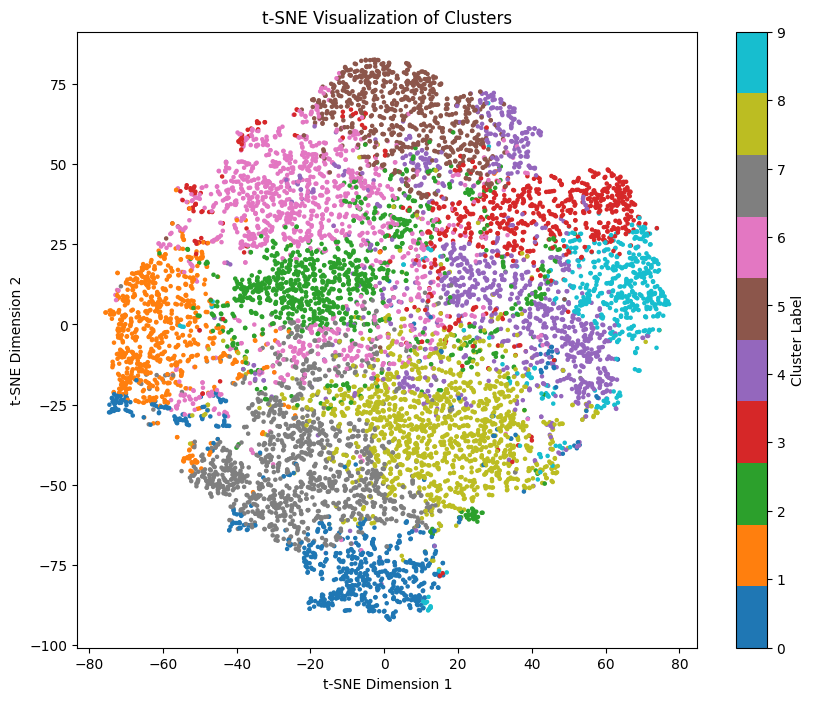

Cluster visualization saved as 'clusters_visualization.png'


In [40]:
# Load Data
transform = SimpleTransform()
dataset = datasets.CIFAR10(root='./data', train=False, transform=transform, download=True)
dataloader = DataLoader(dataset, batch_size=256, shuffle=False, num_workers=4)

# Load Trained Model
simpleCLR = load_model()

# Evaluate Clustering
visualize_clusters(simpleCLR, dataloader, num_clusters=10)

The image represents a t-SNE visualization of clusters formed by the embeddings learned through the Contrastive Learning model, clustered using K-Means.

* There is visible separation between clusters, indicating that the model has effectively learned meaningful features to distinguish between different image categories.
* However, some overlap is noticeable between certain clusters, which may suggest similarities or ambiguities in the corresponding image categories.
* Some clusters are more tightly grouped, indicating strong intra-class similarity in the learned embeddings.
* The overall clear separation between most clusters demonstrates that the model successfully learned representations that capture key differences between image categories.